<a href="https://colab.research.google.com/github/Savithmee/CM2604--Machine-Learning-/blob/main/Input_Validation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INPUT VALIDATION MODEL

####Mount and Setup

In [18]:
from google.colab import drive
drive.mount('/content/drive')

import random, shutil, os
from pathlib import Path
from PIL import Image
import tensorflow as tf

SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)

INPUT_DIR  = Path("/content/drive/MyDrive/DSGP_Group_32/NĀGA/Input Validation Model/Dataset")
BASE_OUT   = Path("/content/drive/MyDrive/DSGP_Group_32/NĀGA/Input Validation Model/Outputs")
IMG_SIZE = (224,224)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

EXTS = {".jpg",".jpeg",".png",".webp",".bmp",".gif",".tif",".tiff"}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Helper Functions (File/Folder + JPG Convert)

In [19]:
def make_clean_dir(path: Path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def list_all_images(folder: Path):
    return [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in EXTS]

def save_as_jpg(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    img = Image.open(src).convert("RGB")
    img.save(dst, format="JPEG", quality=95)

def gather_images(folders):
    files = []
    for fd in folders:
        if not fd.exists():
            raise FileNotFoundError(f" Missing folder: {fd}")
        files.extend(list_all_images(fd))
    return files

####Split and Save Function

In [22]:
def split_and_save(sources: dict, out_dir: Path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    make_clean_dir(out_dir)
    for sp in ["train","val","test"]:
        for cls in sources.keys():
            (out_dir/sp/cls).mkdir(parents=True, exist_ok=True)

    for cls, folders in sources.items():
        files = gather_images(folders)
        print(f" {cls} total:", len(files))
        if len(files)==0:
            raise ValueError(f" No images found for class {cls}")

        random.shuffle(files)
        n = len(files)
        n_train = int(n*train_ratio)
        n_val   = int(n*val_ratio)

        splits = {
            "train": files[:n_train],
            "val":   files[n_train:n_train+n_val],
            "test":  files[n_train+n_val:]
        }

        for sp, flist in splits.items():
            dst_dir = out_dir/sp/cls
            for f in flist:
                if not f.exists():
                    continue
                out = dst_dir / f"{f.stem}.jpg"
                if out.exists():
                    out = dst_dir / f"{f.stem}_{random.randint(1000,9999)}.jpg"
                try:
                    save_as_jpg(f, out)
                except Exception as e:
                    print("⚠ Skip:", f.name, "|", e)

        print(f" {cls} -> train:{len(splits['train'])} val:{len(splits['val'])} test:{len(splits['test'])}")

####Dataset Loader Functions (Binary + Multiclass)

In [23]:
def load_binary(out_dir: Path, class_names):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        str(out_dir/"train"),
        class_names=class_names,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=True,
        seed=SEED
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        str(out_dir/"val"),
        class_names=class_names,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=False
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        str(out_dir/"test"),
        class_names=class_names,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=False
    )
    return train_ds, val_ds, test_ds

def load_multiclass(out_dir: Path, class_names):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        str(out_dir/"train"),
        class_names=class_names,
        label_mode="int",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=True,
        seed=SEED
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        str(out_dir/"val"),
        class_names=class_names,
        label_mode="int",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=False
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        str(out_dir/"test"),
        class_names=class_names,
        label_mode="int",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=False
    )
    return train_ds, val_ds, test_ds

Total images found: 15737


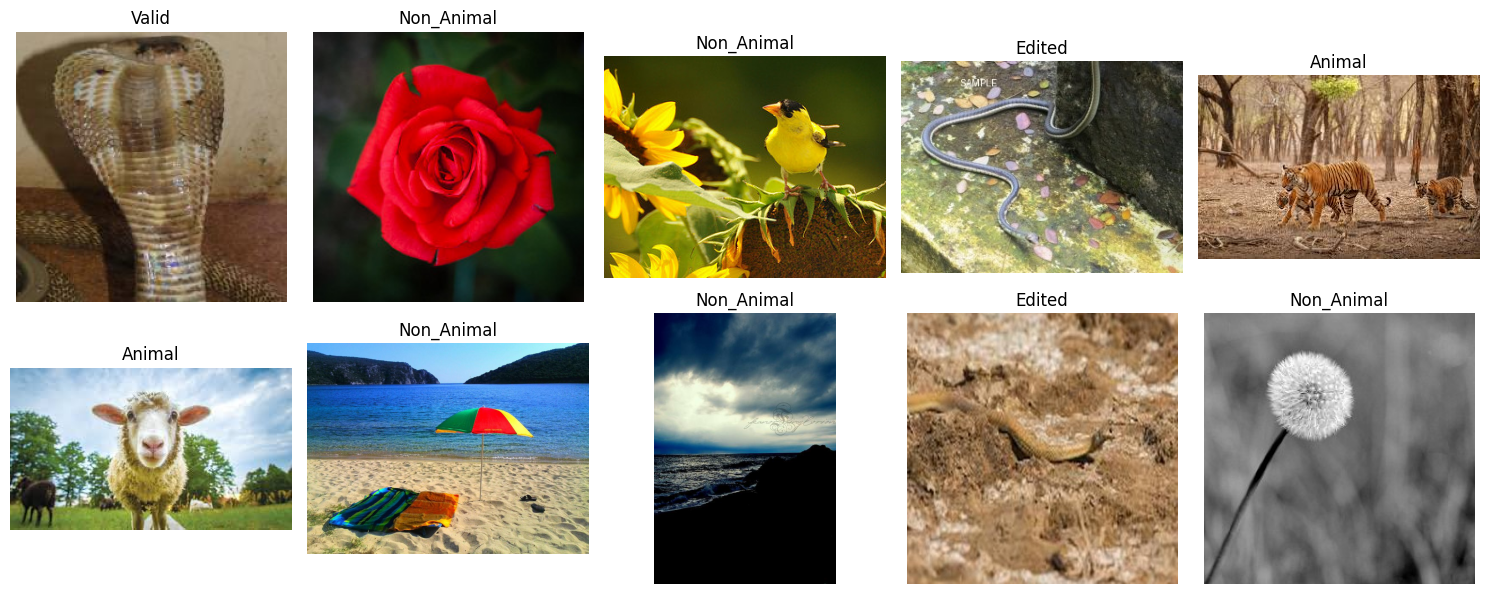

In [25]:
import matplotlib.pyplot as plt
import random

# Get all image paths
all_imgs = list_all_images(INPUT_DIR)

print("Total images found:", len(all_imgs))

# Select 10 random images
sample_imgs = random.sample(all_imgs, min(10, len(all_imgs)))

plt.figure(figsize=(15,6))

for i, img_path in enumerate(sample_imgs):
    img = Image.open(img_path).convert("RGB")

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(img_path.parent.name)
    plt.axis("off")

plt.tight_layout()
plt.show()